In [1]:
from pathlib import Path

import ee
import eemont  # noqa: F401
import geemap
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from bisonlab.data import landsat_7_sr, landsat_8_sr, landsat_9_sr
from bisonlab.io import kml_to_geodataframe
from bisonlab.utils import mask_exclude

In [2]:
# ee.Authenticate()
ee.Initialize()

## Load Parcels and Masks

In [4]:
# Set path to local data directory
local_data = Path().cwd().parent.parent.parent / "data" / "local"

In [5]:
df_parcels = kml_to_geodataframe(local_data / "WRTBI-Morton Soil Types.kml")

df_parcels = df_parcels.rename(columns={"Name": "subsection", "layer": "parcel"})
df_parcels = df_parcels.drop(columns="Description")

# Union all "mask" polygons and create a separate mask dataframe
idx = df_parcels["parcel"] == "mask"
df_mask = df_parcels[idx].dissolve(by="parcel").reset_index()

# Drop "mask" from parcel dataframe
df_parcels = df_parcels.drop(index=idx.index[idx])

# Convert parcels dataframe to ee.featureCollection
parcels = geemap.geopandas_to_ee(df_parcels)
mask = geemap.geopandas_to_ee(df_mask)

In [6]:
df_parcels

,subsection,geometry,parcel
0,High Steppe Unirrigated 1,"POLYGON ((-108.79089 43.19890, -108.79081 43.1...",Shoshone Tribe
1,High Steppe Unirrigated 2,"POLYGON ((-108.78826 43.20636, -108.79311 43.2...",Shoshone Tribe
2,High Steppe Unirrigated 3,"POLYGON ((-108.78802 43.20623, -108.78813 43.2...",Shoshone Tribe
3,High Steppe Unirrigated 4,"POLYGON ((-108.79089 43.20229, -108.78865 43.2...",Shoshone Tribe
4,River Bottom 1,"POLYGON ((-108.79085 43.19374, -108.78828 43.1...",Shoshone Tribe
5,River Bottom 2,"POLYGON ((-108.78594 43.19561, -108.78649 43.1...",Shoshone Tribe
6,River Bottom 3,"POLYGON ((-108.79601 43.20457, -108.79447 43.2...",Shoshone Tribe
7,River Bottom 1,"POLYGON ((-108.80041 43.19793, -108.80030 43.2...",Hellyer Tribal Lease
8,Irrigated High Steppe 1,"POLYGON ((-108.78852 43.20122, -108.78735 43.2...",Morton
9,Irrigated High Steppe 2,"POLYGON ((-108.77009 43.19749, -108.77011 43.1...",Morton


## Retrieve Landsat Data

In [7]:
from tqdm.auto import tqdm

### Save data locally

In [8]:
source_config = {
    "landsat7": {"source": landsat_7_sr, "years": range(2000, 2023)},
    "landsat8": {"source": landsat_8_sr, "years": range(2013, 2023)},
    "landsat9": {"source": landsat_9_sr, "years": range(2021, 2023)},
}

In [9]:
indices = ["BNDVI", "CIG", "CVI", "EVI", "EVI2", "GARI", "GBNDVI", "GEMI", "GLI", "GNDVI", "GRNDVI", "GVMI", "MNDVI", "NDVI", "NGRDI", "SAVI", "VARI", "MNDWI", "NDWI", "NDDI"]

In [10]:
fc = landsat_8_sr(
    parcels,
    "2015-01-01",
    "2017-12-31"
).spectralIndices(indices)
# fc = landsat_9_sr(
#     parcels,
#     "2021-01-01",
#     "2022-12-31"
# ).spectralIndices(indices)

In [11]:
# Apply mask to each image in the collection
fc_masked = fc.map(lambda img: mask_exclude(img, mask))

# Aggregate data by parcel
ts = fc_masked.getTimeSeriesByRegions(
    reducer=ee.Reducer.mean(),
    collection=parcels,
    bands=indices,
    scale=30,
    dateColumn="date",
    naValue=None,
)

In [12]:
df = geemap.ee_to_pandas(ts)
df["date"] = pd.to_datetime(df["date"])

In [13]:
len(df["date"].unique())

134

In [14]:
df["name"] = df["parcel"] + " - " + df["subsection"]

In [15]:
# melt to long form table
df_long = df.melt(
    id_vars=["date", "subsection", "parcel", "name", "reducer"],
    value_vars=indices,
)

In [16]:
# df_long = df_long.loc[(df_long["value"] <= 10) & (df_long["value"] >= -10)]
df_long = df_long.loc[(df_long["value"] <= 1) & (df_long["value"] >= -1)]

In [17]:
a = df_long.pivot(index=["date", "variable"], columns="name", values="value")

In [18]:
import itertools

In [19]:
def func(df):
    combinations = list(itertools.combinations(df.columns, 2)) 
    new_df = pd.DataFrame()
    for a, b in combinations:
        new_df[f"abs_diff_{a}-{b}"] = (df[a] - df[b]).abs()
    return new_df

In [20]:
b = func(a)

In [21]:
c = b.groupby("variable").mean()

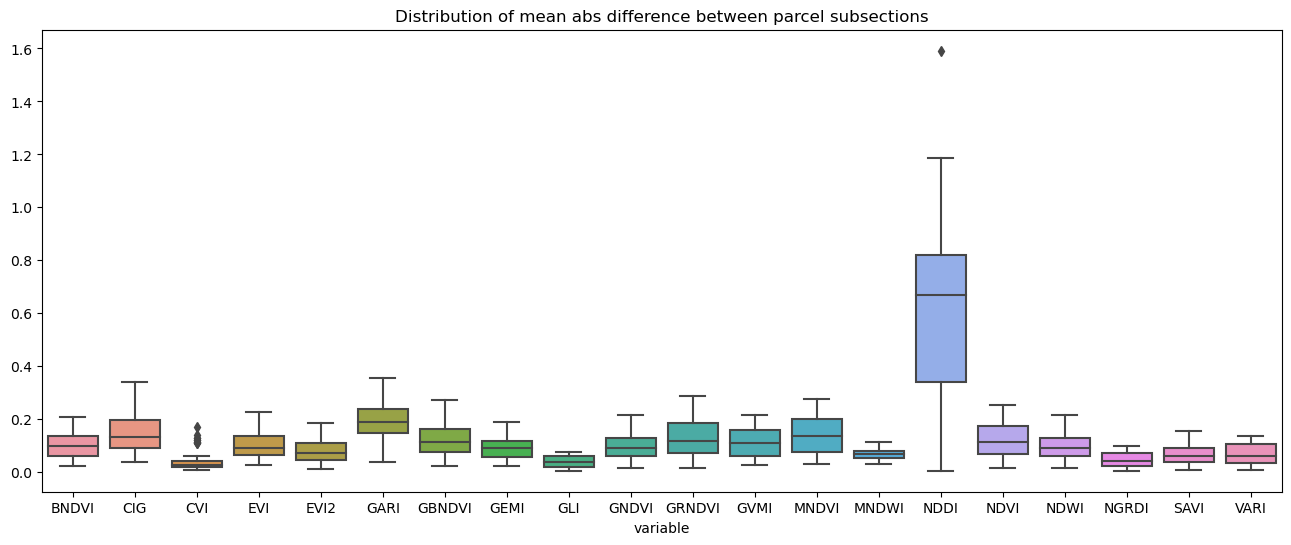

In [22]:
fig, ax = plt.subplots(figsize=(16,6));
sns.boxplot(c.T, ax=ax);
ax.set_title("Distribution of mean abs difference between parcel subsections");
# sns.catplot(c.T, height=5, aspect=3);

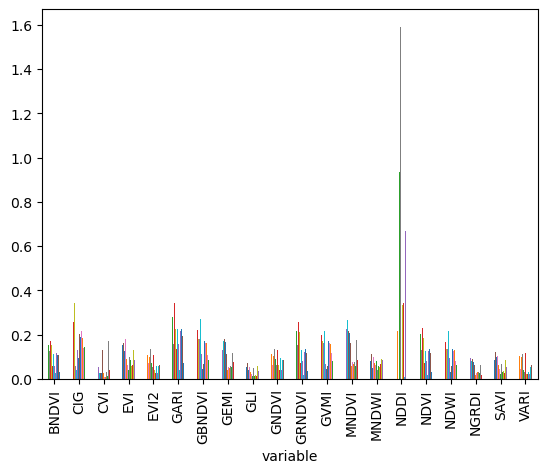

In [23]:
c.plot.bar(legend=False);

In [24]:
df_plot = df_long.loc[
    df_long["name"].eq("Shoshone Tribe - High Steppe Unirrigated 1")
]

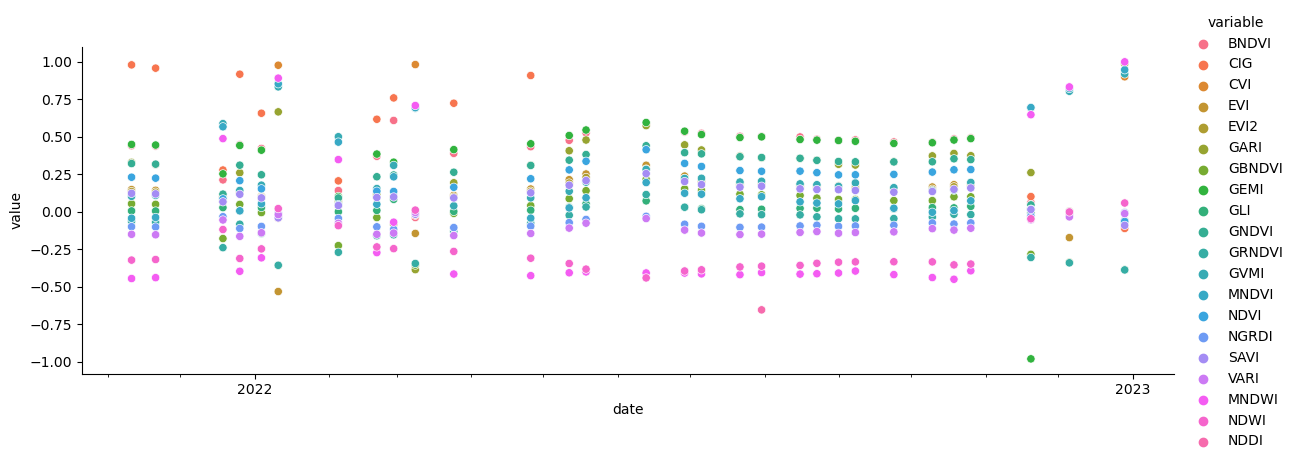

In [169]:
g = sns.relplot(
    data=df_plot,
    x="date",
    y="value",
    hue="variable",
    # col_wrap=1,
    kind="scatter",
    height=4,
    aspect=3,
    facet_kws=dict(sharey=False),
)
g.ax.xaxis.set_major_locator(mdates.YearLocator())
g.ax.xaxis.set_minor_locator(mdates.MonthLocator())

In [170]:
a = df_long.groupby(["name", "variable"]).describe()
a.columns = a.columns.droplevel()

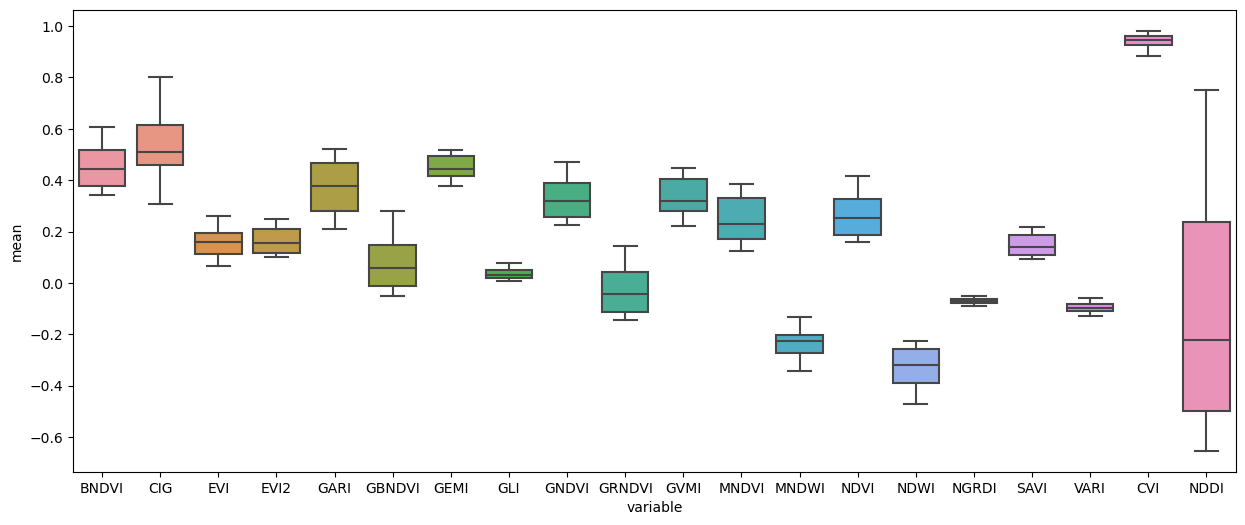

In [173]:
fig, ax = plt.subplots(figsize=(15, 6));
# sns.boxplot(data=df_long, x="variable", y="value", ax=ax);
sns.boxplot(data=a["mean"].reset_index(), x="variable", y="mean", ax=ax);

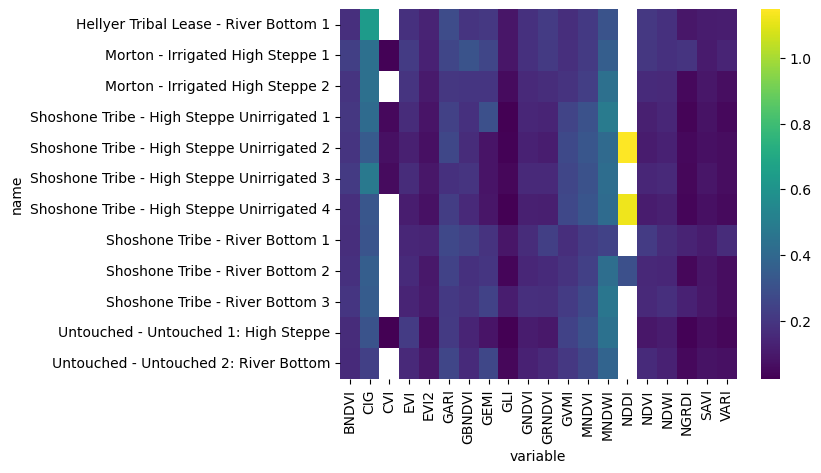

In [177]:
sns.heatmap(a["mean"].unstack(), cmap='viridis');#, vmin=-1, vmax=1);
# sns.heatmap((a["75%"]-a["25%"]).unstack(), cmap='viridis');

In [107]:
a.columns = a.columns.droplevel()

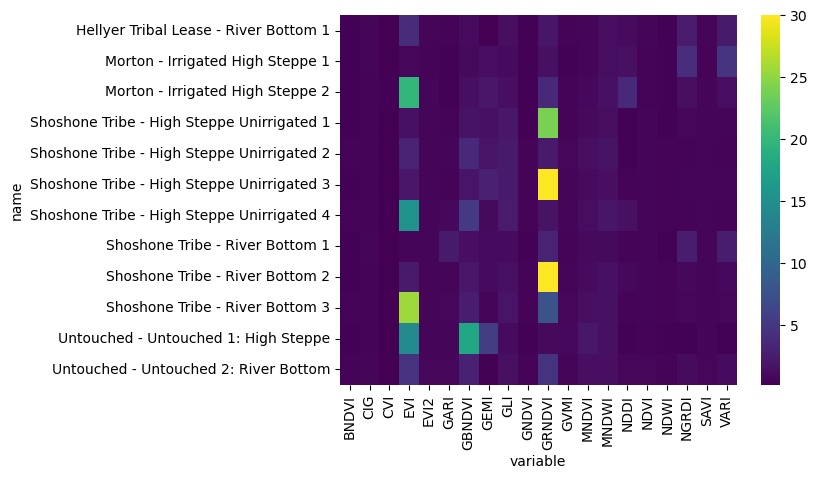

In [111]:
sns.heatmap((a["std"] / a["mean"]).unstack().abs(), cmap='viridis', vmax=30);

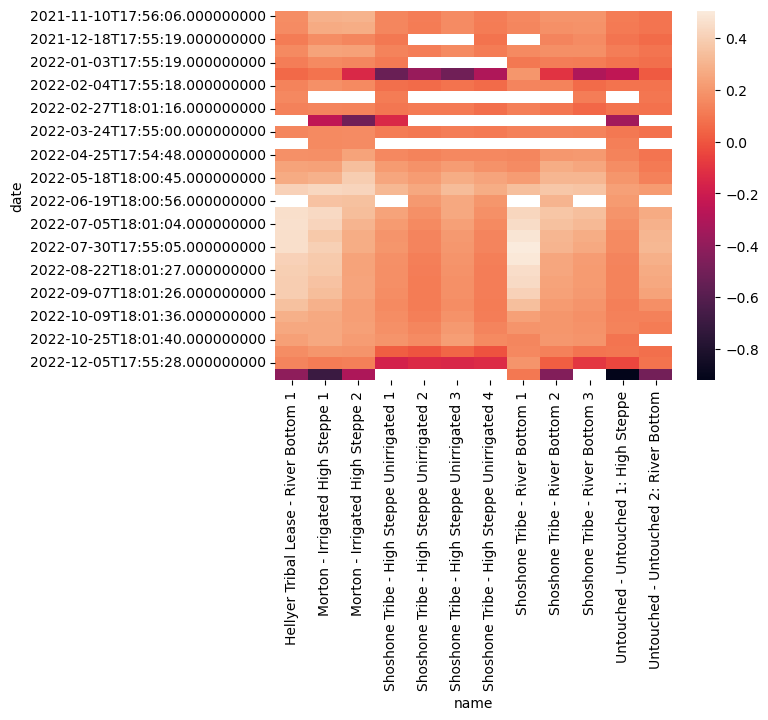

In [209]:
sns.heatmap(
    df_long.loc[
        df_long["variable"].eq(
            # "NDVI"
            "EVI"
            # "EVI2"
            # "BNDVI", "CIG", "CVI", "EVI", "EVI2", "GARI", "GBNDVI", "GEMI", "GLI", "GNDVI", "GRNDVI", "GVMI", "MNDVI", "NDVI", "NGRDI", "SAVI", "VARI", "MNDWI", "NDWI", "NDDI"
            
        )
    ].pivot(index="date", columns="name", values="value")
);

In [ ]:
name = "Shoshone Tribe - High Steppe Unirrigated 1"
a = ndvi.loc[ids[:, name], :].reset_index(level="name", drop=True).sort_values("date")

fig, ax = plt.subplots(figsize=(15, 4))
ax.errorbar(
    x=a.index,
    y=a["mean"],
    yerr=a["stdDev"],
    fmt=".",
    linewidth=0,
    elinewidth=0.5,
    color="k",
    capthick=0.5,
    capsize=1,
)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.set_ylabel("NDVI")
ax.set_title(name + " : NDVI")
fig.tight_layout()
fig.savefig(local_data / f"{name}_ndvi.png", dpi=240)

### Plot Monthly Mean Per Year

In [ ]:
b = a.copy()
b["month"] = b.index.month
b["year"] = b.index.year

c = b.pivot_table(index="year", columns="month", values="mean", aggfunc="mean")

fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(c, ax=ax, cmap="viridis")
ax.set_title(f"{name} : NDVI")
fig.savefig(local_data / f"{name}_ndvi_monthly.png", dpi=240);